# Boston Housing Prices - Linear Regression in Spark

We'll use [Boston.csv](https://www.datasciencecentral.com/profiles/blogs/boston-housing-dataset-without-the-racial-profiling-field) data set in order to predict housing prices in Boston. This data is from [Kaggle competition: Housing Values in Suburbs of Boston](https://www.kaggle.com/c/boston-housing/data) without the 'black' column.

Bellow are the features and the output (MEDV):
- CRIM — per capita crime rate by town.
- ZN — proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS — proportion of non-retail business acres per town.
- CHAS — Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
- NOX — nitrogen oxides concentration (parts per 10 million).
- RM — average number of rooms per dwelling.
- AGE — proportion of owner-occupied units built prior to 1940.
- DIS — weighted mean of distances to five Boston employment centres.
- RAD — index of accessibility to radial highways.
- TAX — full-value property-tax rate per $10,000.
- PTRATIO — pupil-teacher ratio by town.
- LSTAT — lower status of the population (percent).

- MEDV — median value of owner-occupied homes in $1000s. This is the target variable.



First, let's import some useful libraries and get Spark Context, so we can load the dataset that was previously downloaded:

In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
import pandas as pd
import seaborn as sns
%matplotlib inline

In [4]:
sc= SparkContext()
sqlContext = SQLContext(sc)
house_df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('boston.csv')

[Row(CRIM=0.00632,  ZN =18.0, INDUS =2.31, CHAS=0, NOX=0.538, RM=6.575, AGE=65.2, DIS=4.09, RAD=1, TAX=296, PTRATIO=15.3, LSTAT=4.98, MEDV=24.0)]

## Data exploration

In [19]:
house_df.show(5)

+-------+----+------+----+-----+-----+----+------+---+---+-------+-----+----+
|   CRIM| ZN |INDUS |CHAS|  NOX|   RM| AGE|   DIS|RAD|TAX|PTRATIO|LSTAT|MEDV|
+-------+----+------+----+-----+-----+----+------+---+---+-------+-----+----+
|0.00632|18.0|  2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 4.98|24.0|
|0.02731| 0.0|  7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 9.14|21.6|
|0.02729| 0.0|  7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8| 4.03|34.7|
|0.03237| 0.0|  2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7| 2.94|33.4|
|0.06905| 0.0|  2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 5.33|36.2|
+-------+----+------+----+-----+-----+----+------+---+---+-------+-----+----+
only showing top 5 rows



In [21]:
house_df.printSchema()

root
 |-- CRIM: double (nullable = true)
 |--  ZN : double (nullable = true)
 |-- INDUS : double (nullable = true)
 |-- CHAS: integer (nullable = true)
 |-- NOX: double (nullable = true)
 |-- RM: double (nullable = true)
 |-- AGE: double (nullable = true)
 |-- DIS: double (nullable = true)
 |-- RAD: integer (nullable = true)
 |-- TAX: integer (nullable = true)
 |-- PTRATIO: double (nullable = true)
 |-- LSTAT: double (nullable = true)
 |-- MEDV: double (nullable = true)



Print some useful information about the data using pandas, like mean, stddev and the correlation matrix:

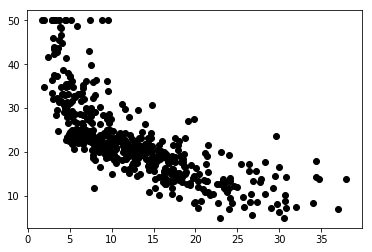

In [31]:
import matplotlib.pyplot as plt

house_df_pd = house_df.toPandas()

X = house_df_pd.LSTAT
y = house_df_pd.MEDV
plt.scatter(X, y,  color='black')

In [22]:
house_df_pd = house_df.toPandas()

house_desc = house_df_pd.describe()
house_desc.transpose()

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


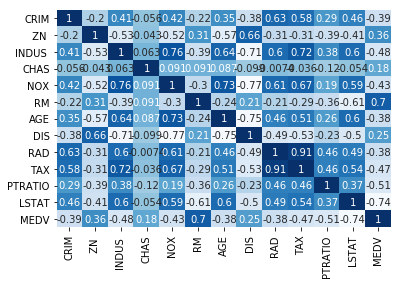

In [23]:
sns.heatmap(house_df_pd.corr(), cbar=False, annot=True, cmap="Blues")

If it's not practinal to work with pandas, you can calculate the same result in Spark:

In [10]:
import six
for i in house_df.columns:
    if not( isinstance(house_df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to MEDV for ", i, house_df.stat.corr('MEDV',i))

Correlation to MEDV for  CRIM -0.38830460858681154
Correlation to MEDV for   ZN  0.3604453424505433
Correlation to MEDV for  INDUS  -0.4837251600283728
Correlation to MEDV for  CHAS 0.1752601771902987
Correlation to MEDV for  NOX -0.4273207723732821
Correlation to MEDV for  RM 0.6953599470715401
Correlation to MEDV for  AGE -0.3769545650045961
Correlation to MEDV for  DIS 0.249928734085904
Correlation to MEDV for  RAD -0.38162623063977735
Correlation to MEDV for  TAX -0.46853593356776674
Correlation to MEDV for  PTRATIO -0.5077866855375622
Correlation to MEDV for  LSTAT -0.7376627261740145
Correlation to MEDV for  MEDV 1.0


## Create a new data frame in the format the model requires
First we'll try to use only one feature to predic the value of MEDV.

In [32]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['LSTAT'], outputCol = 'features')
vhouse_df = vectorAssembler.transform(house_df)
vhouse_df = vhouse_df.select(['features', 'MEDV'])
vhouse_df.show(3)

+--------+----+
|features|MEDV|
+--------+----+
|  [4.98]|24.0|
|  [9.14]|21.6|
|  [4.03]|34.7|
+--------+----+
only showing top 3 rows



### Split the data
It is necessary to split the data in 2 sets, the first for trainning and the second for tests. We'll use 70% of data for training and 30% for tests.

In [33]:
splits = vhouse_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

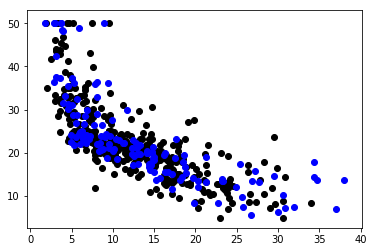

In [42]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

X = [float(row[0]) for row in X.collect()]
y = [float(row['MEDV']) for row in train_df.collect()]

xTest = test_df.select(firstelement('features'))
xTest = [float(row[0]) for row in xTest.collect()]
yTest = [float(row['MEDV']) for row in test_df.collect()]

plt.scatter(X, y,  color='black')
plt.scatter(xTest, yTest,  color='blue')

## Creates the model and fits it

Print some useful information.

In [34]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='MEDV', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-0.9436676029786976]
Intercept: 34.14558922262857


In [35]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 5.987330
r2: 0.541816


__RMSE__ measures the differences between predicted values by the model and the actual values. However, __RMSE__ alone is meaningless until we compare with the actual “MEDV” value, such as mean, min and max. After such comparison, our RMSE looks pretty good.

__R squared__ indicates that in our model, approximate r2% of the variability in “MEDV” can be explained using the model.

In [38]:
train_df.describe().show()

+-------+------------------+
|summary|              MEDV|
+-------+------------------+
|  count|               363|
|   mean|22.434986225895322|
| stddev| 8.857525700383755|
|    min|               5.0|
|    max|              50.0|
+-------+------------------+



In [43]:
from pyspark.ml.evaluation import RegressionEvaluator

lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","MEDV","features").show(5)

lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="MEDV",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+----+--------+
|        prediction|MEDV|features|
+------------------+----+--------+
| 32.51304426947543|50.0|  [1.73]|
| 31.43726320207971|36.4|  [2.87]|
|31.427826526049923|50.0|  [2.88]|
| 31.34289644178184|50.0|  [2.97]|
|31.210782977364822|42.3|  [3.11]|
+------------------+----+--------+
only showing top 5 rows

R Squared (R2) on test data = 0.544513


In [44]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 6.74969


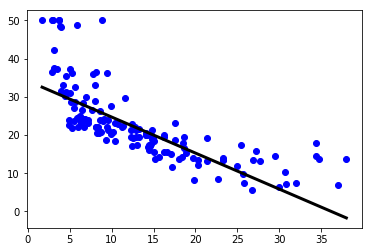

In [48]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

yPred = [float(row["prediction"]) for row in lr_predictions.collect()]

plt.scatter(xTest, yTest,  color='blue')
plt.plot(xTest, yPred, color='black', linewidth=3)

## Multiple Linear Regression

Lets use all features abvailable and analyze if the results are improved.

First, create a vector with all target values, split the data, and then create the classifier.

In [49]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['CRIM', ' ZN ', 'INDUS ', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT'], outputCol = 'features')
vhouse_df = vectorAssembler.transform(house_df)
vhouse_df = vhouse_df.select(['features', 'MEDV'])
vhouse_df.show(3)

+--------------------+----+
|            features|MEDV|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
+--------------------+----+
only showing top 3 rows



In [50]:
splits = vhouse_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [51]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='MEDV',
                      maxIter=50, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-0.043209780141150164,0.017943341608228237,-0.05463744612267766,3.9607879256911525,-10.883430370798754,3.744477798463027,0.0,-1.077268723304534,0.009750704718922715,0.0,-0.6661915129344613,-0.5726101025347289]
Intercept: 29.13831393111888


In [52]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 5.095765
r2: 0.703149


In [53]:
train_df.describe().show()

+-------+------------------+
|summary|              MEDV|
+-------+------------------+
|  count|               361|
|   mean|22.683656509695307|
| stddev|  9.36574336692075|
|    min|               5.0|
|    max|              50.0|
+-------+------------------+



In [54]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","MEDV","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="MEDV",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+----+--------------------+
|        prediction|MEDV|            features|
+------------------+----+--------------------+
|30.658857647000957|24.0|[0.00632,18.0,2.3...|
|30.944450568412623|32.7|[0.01301,35.0,1.5...|
| 29.44478330278419|35.4|[0.01311,90.0,1.2...|
|17.462903739311635|18.9|[0.0136,75.0,4.0,...|
|30.827431026470762|29.1|[0.01439,60.0,2.9...|
+------------------+----+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.747755


In [55]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 4.39616


In [57]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","MEDV","features").show()

+------------------+----+--------------------+
|        prediction|MEDV|            features|
+------------------+----+--------------------+
|30.658857647000957|24.0|[0.00632,18.0,2.3...|
|30.944450568412623|32.7|[0.01301,35.0,1.5...|
| 29.44478330278419|35.4|[0.01311,90.0,1.2...|
|17.462903739311635|18.9|[0.0136,75.0,4.0,...|
|30.827431026470762|29.1|[0.01439,60.0,2.9...|
|26.868711753329155|24.5|[0.01501,80.0,2.0...|
| 24.45600192473082|30.1|[0.01709,90.0,2.0...|
|24.541291553800843|33.0|[0.01951,17.5,1.3...|
| 39.33358335693784|50.0|[0.02009,95.0,2.6...|
|27.434027073454118|25.0|[0.02875,28.0,15....|
|29.108387913809317|31.2|[0.03049,55.0,3.7...|
| 24.36458037851267|19.4|[0.03466,35.0,6.0...|
|21.964440345969543|20.9|[0.03548,80.0,3.6...|
| 29.69935920141786|27.9|[0.03615,80.0,4.9...|
|  33.2905822024232|34.6|[0.03768,80.0,1.5...|
| 25.65836713141197|23.2|[0.03871,52.5,5.3...|
|21.410781426131418|21.1|[0.03961,0.0,5.19...|
|28.406594513973097|28.0|[0.04113,25.0,4.8...|
|25.634131210